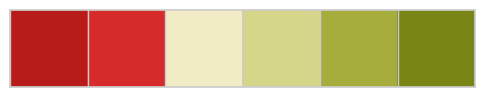

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter

from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# Clustering Algorithms
from sklearn.cluster import DBSCAN
from itertools import product
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# scipy library for hierarchical clustering
from scipy.cluster.hierarchy import ward, dendrogram, linkage
from scipy.cluster import hierarchy
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors
   
colors = ["#B71C1B","#D72A2B","#F2ECC6","#D5D68A","#A6AD3C","#798517"]
colors1 = ["#B71C1B","#D72A2B","#D5D68A","#A6AD3C","#798517"]
colors2 = ["#F2ECC6","#D5D68A","#A6AD3C","#798517","#D72A2B"]
cmap = matplotlib.colors.ListedColormap(colors2)

sns.palplot(sns.color_palette(colors))

In [3]:
Data = pd.read_csv('Customer_Data.csv')

In [5]:
df = pd.DataFrame(Data)
df.head(5)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [7]:
# View dimensions of dataset   
rows, col = df.shape
print ("Dimensions of dataset: {}" . format (df.shape))
print ('Rows:', rows, '\nColumns:', col)

Dimensions of dataset: (8950, 18)
Rows: 8950 
Columns: 18


In [9]:
# Information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

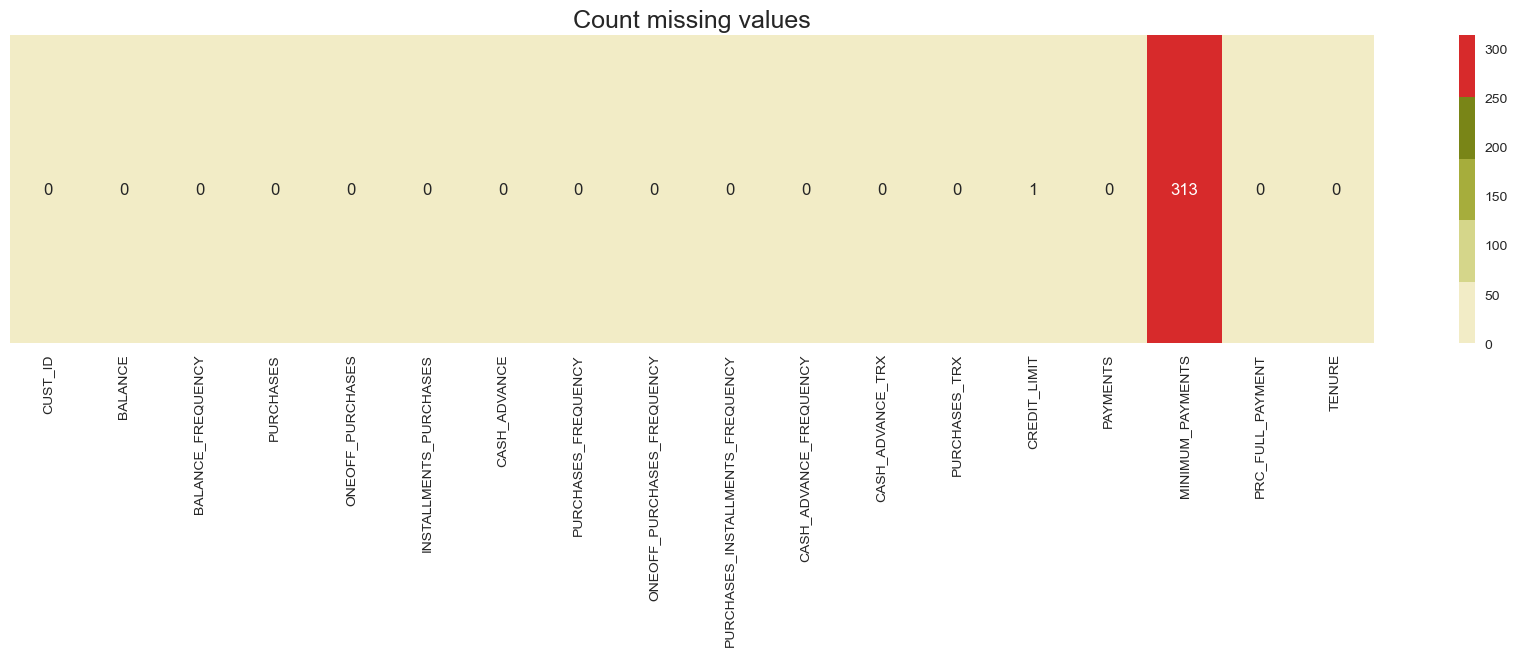

In [11]:
# Missing values
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap=cmap, annot=True,
             fmt='0.0f').set_title('Count missing values', fontsize=18)
plt.show()

In [13]:
# Drop the missing value for 'Credit Limit'
df = df.drop(5203)

# Reset index 
df = df.reset_index(drop=True)

# Dimensions of dataset 
print(df.shape)

(8949, 18)


In [15]:
# Fill missing values in the 'MINIMUM_PAYMENTS' column with the median value
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

# Print the shape of the DataFrame
print(df.shape)

(8949, 18)


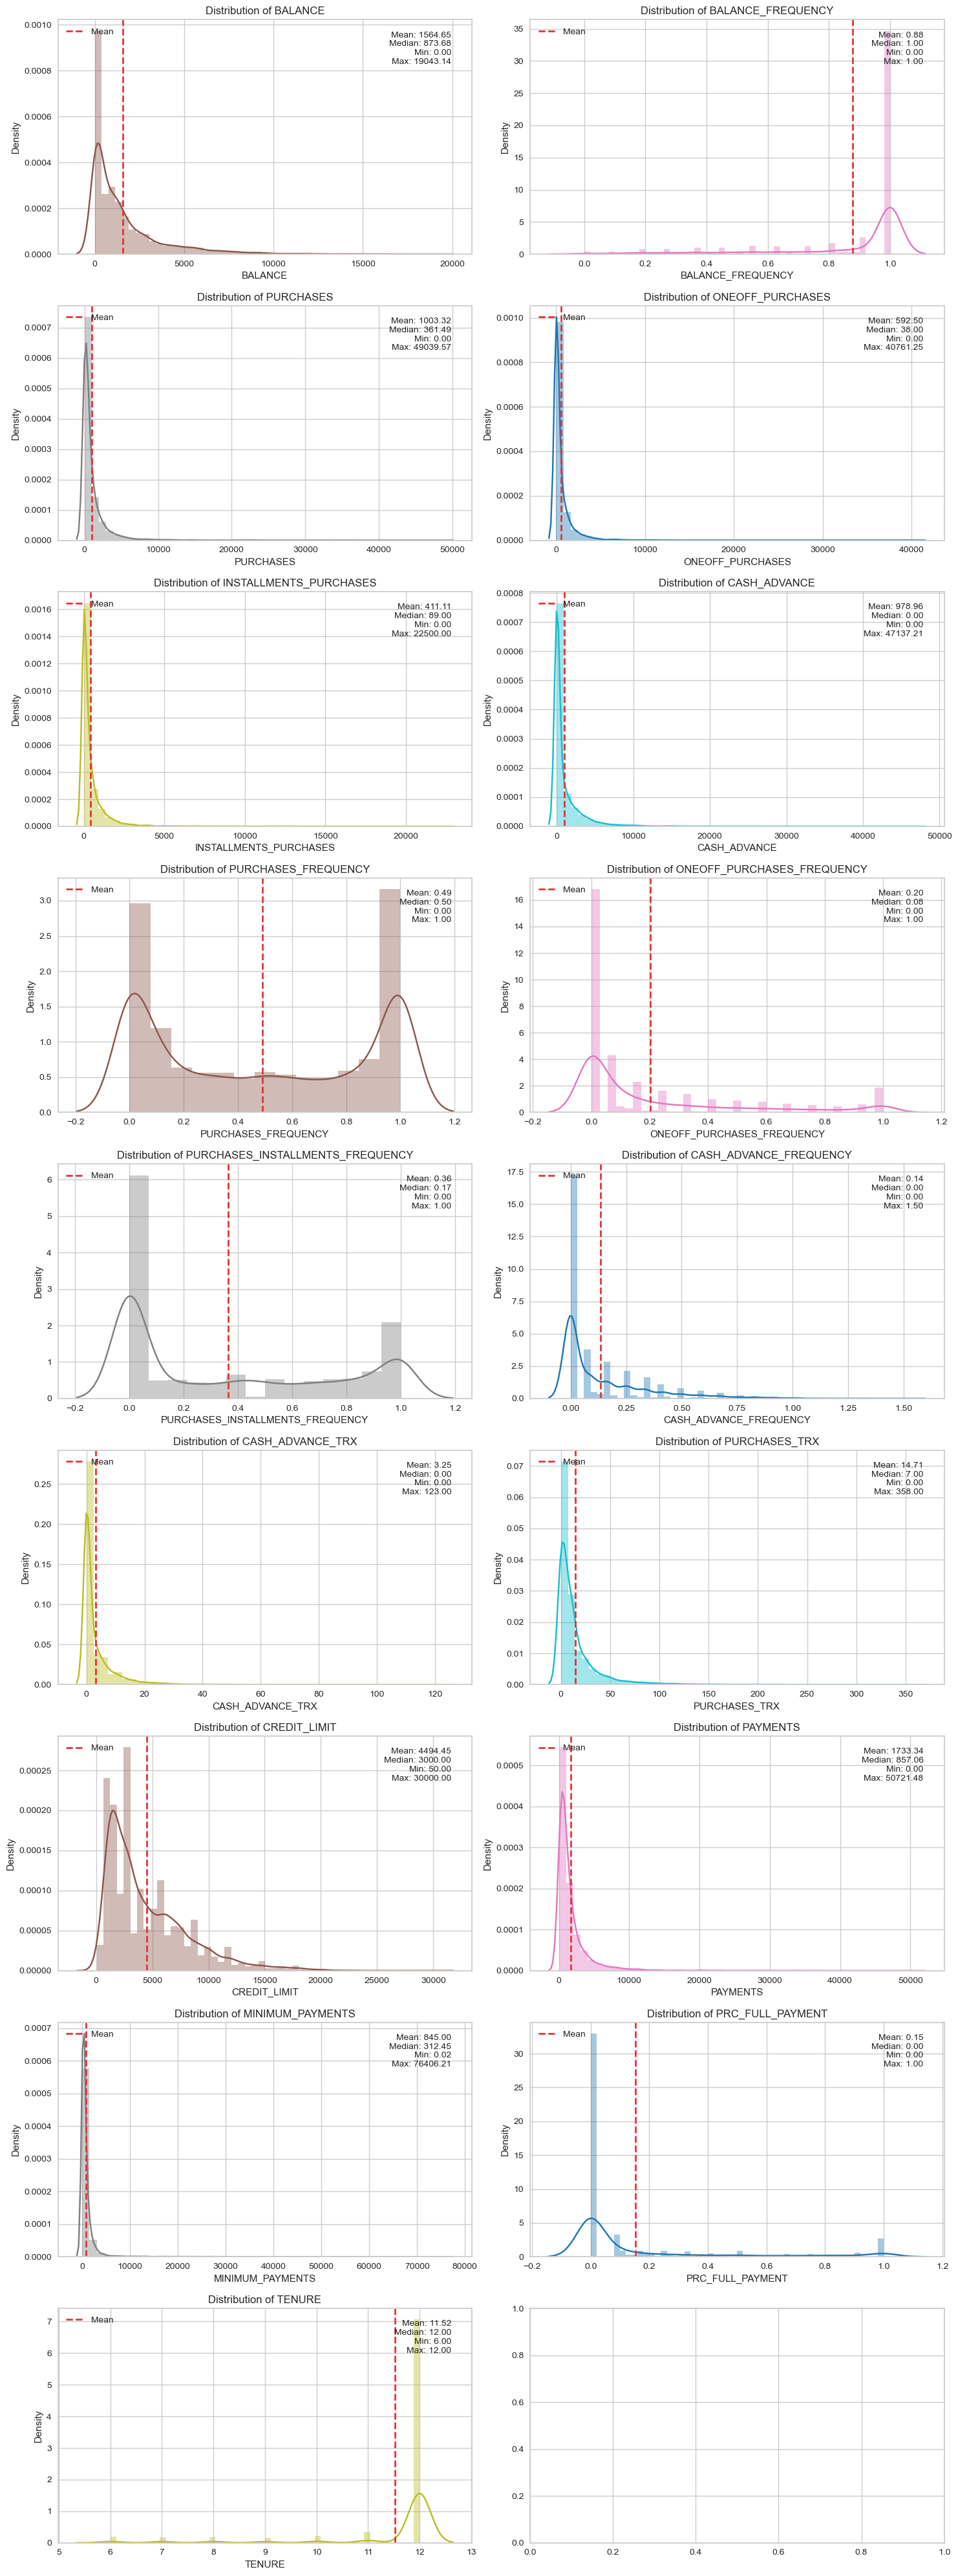

In [17]:
# Check variables distribution
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(15, 40))

# Define colors to use for each feature
colors = ['#8C564B', '#E377C2', '#7F7F7F', '#1F77B4', '#BCBD22', '#17BECF']

# Loop through each column and plot distribution
# Exclude 'CUST_ID' column from the loop as it contains string values
for i, column in enumerate(df.select_dtypes(include=np.number).columns): 
    # Plot histogram with density curve
    sns.distplot(df[column], color=colors[i%len(colors)], ax=axes[i//2, i%2])
    
    # Add vertical lines for mean
    axes[i//2, i%2].axvline(x=df[column].mean(), color='#e33434', linestyle='--', linewidth=2, label='Mean')
    
    # Add text box with important statistics
    median = df[column].median()
    axes[i//2, i%2].text(0.95, 0.95, 
                          'Mean: {:.2f}\nMedian: {:.2f}\nMin: {:.2f}\nMax: {:.2f}'.format(
                              df[column].mean(), median, df[column].min(), df[column].max()),
                          transform=axes[i//2, i%2].transAxes,
                          fontsize=10, va='top', ha='right')
    
    # Add legend
    axes[i//2, i%2].legend(loc="upper left")
    
    # Set title of subplot
    axes[i//2, i%2].set_title('Distribution of '+ column)
    
# Add overall title and adjust spacing
fig.tight_layout()

In [19]:
# Assign the column names of the original DataFrame to the cols variable
# Exclude the 'CUST_ID' column as it is not a numerical feature
cols = df.drop(columns=['CUST_ID']).columns  

# Scale the features using StandardScaler
scaler = StandardScaler()

# Fit the scaler to data and transform it, excluding the 'CUST_ID' column
scaled_col = scaler.fit_transform(df[cols]) # Pass only numerical columns to fit_transform

# Create a DataFrame from the scaled features
scaled_col = pd.DataFrame(scaled_col, columns=cols) # Use the correct column names

scaled_col.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.732054          -0.249881  -0.424934         -0.356957   
1  0.786858           0.134049  -0.469584         -0.356957   
2  0.447041           0.517980  -0.107716          0.108843   
3  0.049015          -1.017743   0.231995          0.546123   
4 -0.358849           0.517980  -0.462095         -0.347317   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349114     -0.466805            -0.806649   
1               -0.454607      2.605438            -1.221928   
2               -0.454607     -0.466805             1.269742   
3               -0.454607     -0.368678            -1.014290   
4               -0.454607     -0.466805            -1.014290   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678716                         -0.707409   
1                   -0.678716                         -0.917090   
2                    2.673295                         -0.917090   
3                   -0.399383                         -0.917090   
4                   -0.399383                         -0.917090   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.675294         -0.476083      -0.511381     -0.960380   
1                0.573949          0.110032      -0.591841      0.688601   
2               -0.675294         -0.476083      -0.109082      0.826016   
3               -0.258882         -0.329554      -0.551611      0.826016   
4               -0.675294         -0.476083      -0.551611     -0.905414   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0 -0.529026         -0.302427         -0.525588  0.360541  
1  0.818546          0.097453          0.234159  0.360541  
2 -0.383857         -0.093330         -0.525588  0.360541  
3 -0.598733         -0.228291         -0.525588  0.360541  
4 -0.364421         -0.257295         -0.525588  0.360541

In [21]:
# Define range of eps and min_samples values to be investigated
eps_range = np.arange(0.1, 1.5, 0.1)
min_samples_range = np.arange(2, 10, 1)

# Find all possible combinations of eps and min_samples values
params_grid = pd.DataFrame(list(product(eps_range, min_samples_range)), columns=['eps', 'min_samples'])
params_grid.T

0    1    2    3    4    5    6    7    8    9    ...  102  103  \
eps          0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.2  0.2  ...  1.3  1.3   
min_samples  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  2.0  3.0  ...  8.0  9.0   

             104  105  106  107  108  109  110  111  
eps          1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  
min_samples  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  

[2 rows x 112 columns]

In [27]:
silhouette_coef = []
calinski_harabasz_coef = []
for _, row in params_grid.iterrows():
    dbscan = DBSCAN(eps=row['eps'], min_samples=int(row['min_samples'])) # Convert min_samples to int
    labels = dbscan.fit_predict(scaled_col)
    score_silhouette = silhouette_score(scaled_col, labels)
    silhouette_coef.append(score_silhouette)

    dbscan.fit(scaled_col)
    score_calinski_harabasz = calinski_harabasz_score(scaled_col, dbscan.labels_)
    calinski_harabasz_coef.append(score_calinski_harabasz)

In [30]:
# Create a dataframe to store the scores
scores_DBSCAN = pd.DataFrame({'eps': params_grid['eps'],
                              'min_samples': params_grid['min_samples'],
                              'Silhouette Score': silhouette_coef,
                              'Calinski-Harabasz Score': calinski_harabasz_coef})

# Find the best eps and min_samples for each score
best_params_silhouette = scores_DBSCAN.loc[scores_DBSCAN['Silhouette Score'].idxmax(), ['eps', 'min_samples']]
best_params_calinski_harabaz = scores_DBSCAN.loc[scores_DBSCAN['Calinski-Harabasz Score'].idxmax(), ['eps', 'min_samples']]

In [32]:
print("\nScores for Different Hyperparameters:")
scores_DBSCAN.style.background_gradient(cmap=cmap).set_properties(**{'font-family': 'Segoe UI'}).hide(axis="index")


Scores for Different Hyperparameters:


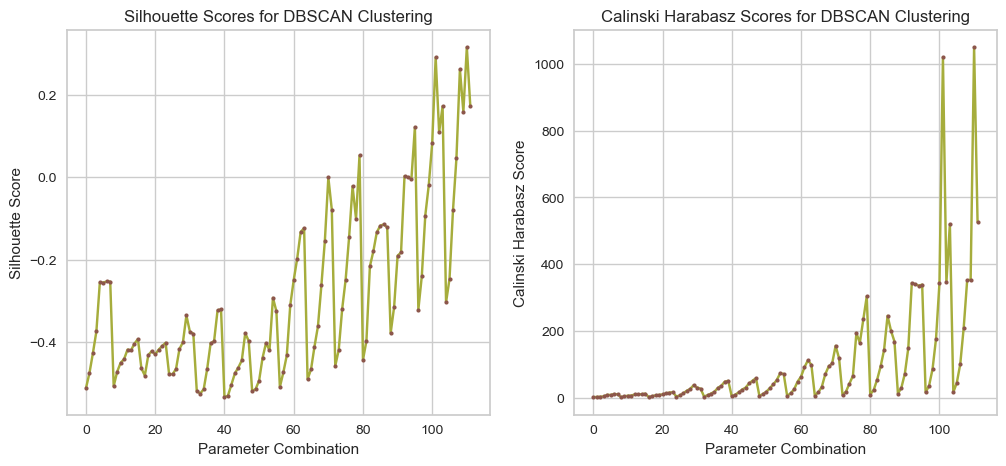

In [34]:
# Visualize plots of silhouette and calinski harabasz scores
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot silhouette scores
ax1.plot(params_grid.index, silhouette_coef, color="#A6AD3C", marker='o', ms=3, mfc=colors[0])
ax1.set_title('Silhouette Scores for DBSCAN Clustering')
ax1.set_xlabel('Parameter Combination')
ax1.set_ylabel('Silhouette Score')

# Plot calinski harabasz scores
ax2.plot(params_grid.index, calinski_harabasz_coef, color="#A6AD3C", marker='o', ms=3, mfc=colors[0])
ax2.set_title('Calinski Harabasz Scores for DBSCAN Clustering')
ax2.set_xlabel('Parameter Combination')
ax2.set_ylabel('Calinski Harabasz Score')

plt.show()

In [38]:
# Best parameters for each score
print(f"\n▪️Best Parameters for Silhouette Score: eps = {best_params_silhouette['eps']}, min_samples = {best_params_silhouette['min_samples']}")
print(f"▪️Best Parameters for Calinski-Harabasz Score: eps = {best_params_calinski_harabaz['eps']}, min_samples = {best_params_calinski_harabaz['min_samples']}")


▪️Best Parameters for Silhouette Score: eps = 1.4000000000000001, min_samples = 8.0
▪️Best Parameters for Calinski-Harabasz Score: eps = 1.4000000000000001, min_samples = 8.0


In [40]:
# Implement DBSCAN for best eps and min_sample
dbscan = DBSCAN(eps=1.4, min_samples=8)
dbscan.fit(scaled_col)

# Store result of DBSCAN
pred = dbscan.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(pred)) - (1 if -1 in pred else 0)
n_noise_ = list(pred).count(-1)

In [44]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print('------------------------------------')
print(f"Number of cluster: {np.unique(pred)}")

Estimated number of clusters: 1
Estimated number of noise points: 1745
------------------------------------
Number of cluster: [-1  0]


In [46]:
# Calculate scores
silhouette = silhouette_score(scaled_col, pred)
calinski = calinski_harabasz_score(scaled_col, pred)

# Create a DataFrame with the scores
DBSCAN_scores = pd.DataFrame({'Silhouette Score': [silhouette], 'Calinski-Harabasz Score': [calinski]}, index=['DBSCAN (Low Range of Hyperparameters)'])
DBSCAN_scores

Silhouette Score  \
DBSCAN (Low Range of Hyperparameters)           0.31573   

                                       Calinski-Harabasz Score  
DBSCAN (Low Range of Hyperparameters)               1049.99649

In [48]:
dbscan_clustered_df = pd.concat([df, pd.DataFrame(pred, columns=['DBSCAN Cluster'])], axis = 1)
dbscan_clustered_df.head(10).style.set_properties(**{'background-color': '#F2ECC6'}, subset=['DBSCAN Cluster'])

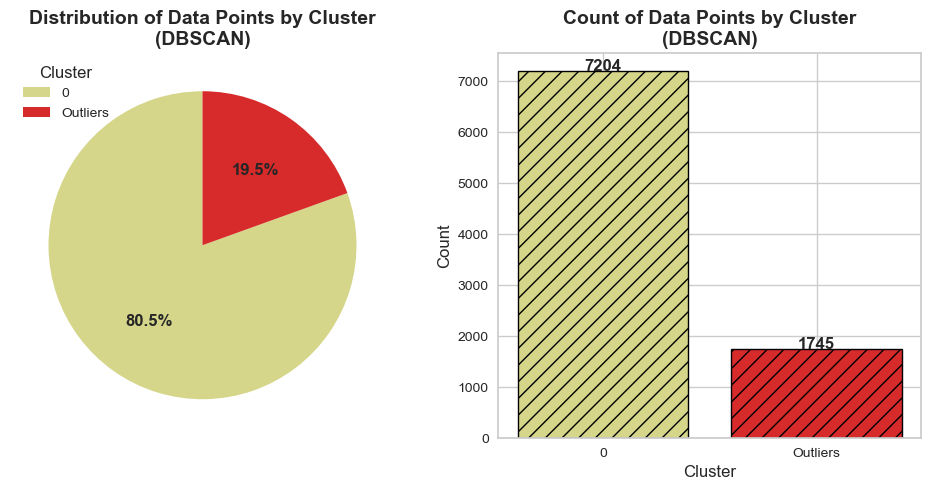

In [50]:
# Create data for the pie chart
counts = dbscan_clustered_df['DBSCAN Cluster'].value_counts()
counts.index = counts.index.astype(str)
counts['Outliers'] = counts.pop('-1')
labels = counts.index.tolist()
sizes = counts.tolist()

# Define the color palette
colors = ["#D5D68A", "#D72A2B"]

# Create the figure and axis objects
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# Create the pie chart
pie_chart = ax1.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

# Add legend to the pie chart
ax1.legend(pie_chart[0], labels, loc="best", title='Cluster')

# Add title to the pie chart
ax1.set_title("Distribution of Data Points by Cluster\n(DBSCAN)", fontsize=14, fontweight='bold')

# Create the bar plot
bar_plot = ax2.bar(labels, sizes, color=colors, edgecolor='black', linewidth=1, hatch='//')

# Add title to the bar plot
ax2.set_xlabel('Cluster', fontsize= 12)
ax2.set_ylabel('Count', fontsize= 12)
ax2.set_title("Count of Data Points by Cluster\n(DBSCAN)", fontsize=14, fontweight='bold')

# Add labels to the bar plot
for i, v in enumerate(sizes):
    ax2.text(i, v+10, str(v), ha='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()

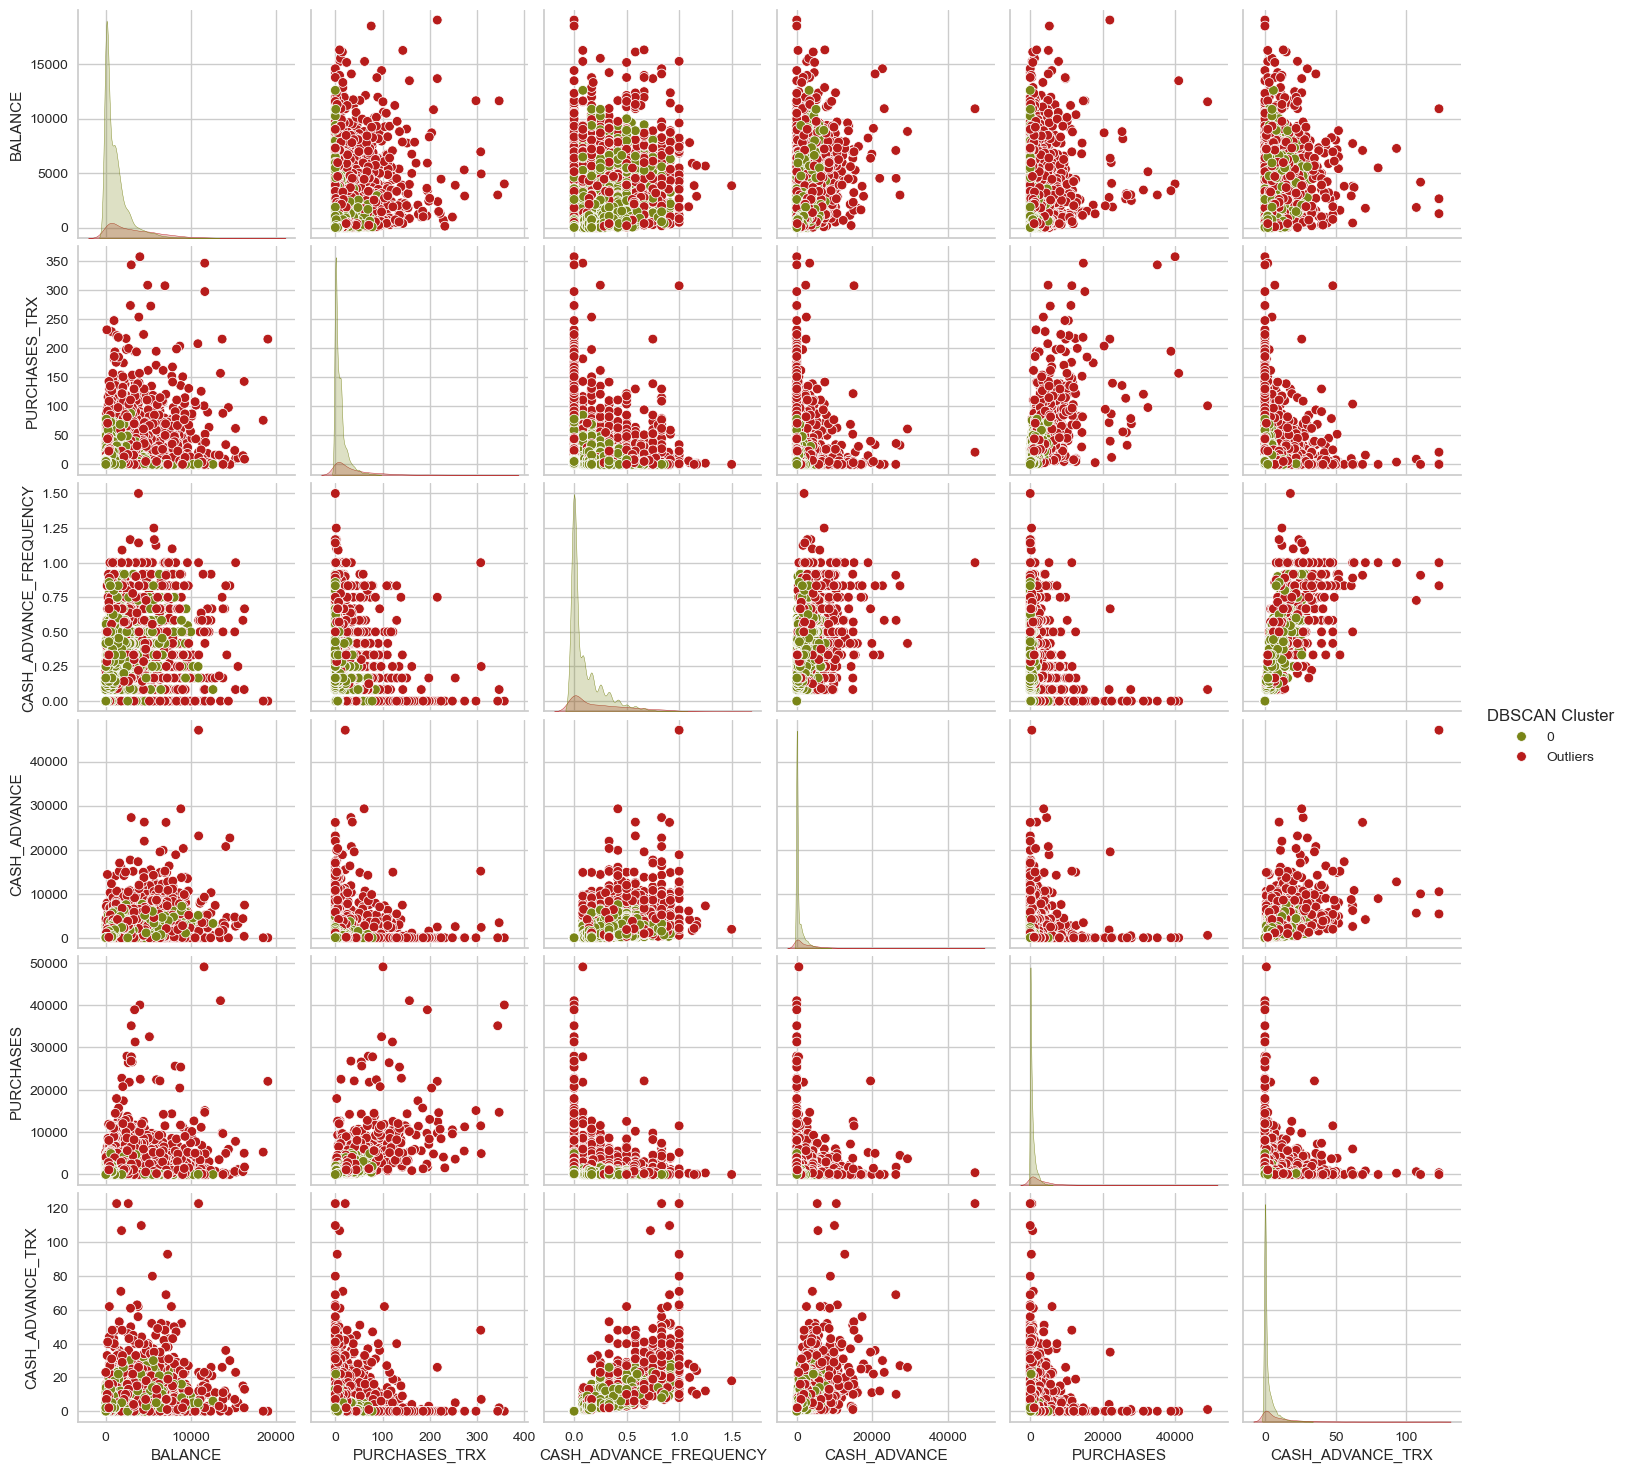

In [52]:
colors = ["#798517", "#B71C1B"]
important_variables = ['BALANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE', 'PURCHASES', 'CASH_ADVANCE_TRX', 'DBSCAN Cluster']

dbscan_clustered_df['DBSCAN Cluster'] = dbscan_clustered_df['DBSCAN Cluster'].replace(-1, 'Outliers')

sns.set_palette(colors)
sns.pairplot(dbscan_clustered_df[important_variables], hue='DBSCAN Cluster')
plt.show()

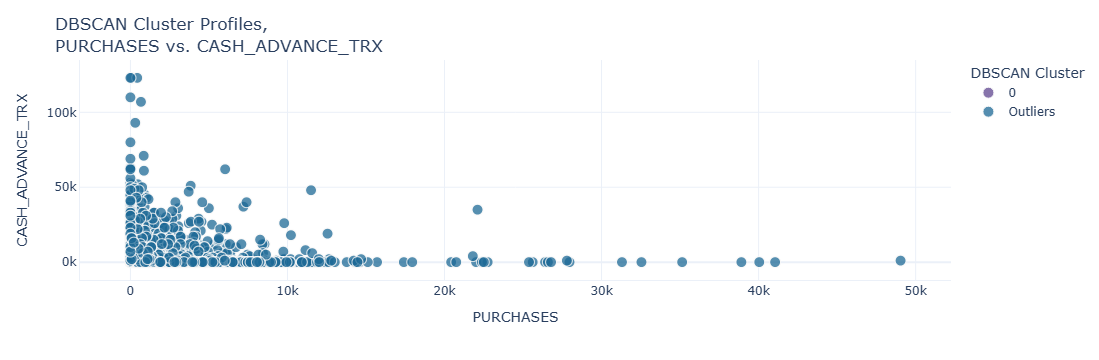

In [66]:
# Plot of clusters
import plotly.io as pio 

fig = px.scatter(dbscan_clustered_df, x="PURCHASES", y="CASH_ADVANCE_TRX", color="DBSCAN Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))

# Use pio.templates['plotly_dark'] to access the template
fig.update_layout(template=pio.templates['plotly_white'], title="DBSCAN Cluster Profiles,<br>PURCHASES vs. CASH_ADVANCE_TRX", 
                  width=700, legend_title='DBSCAN Cluster',
                  xaxis=dict(title='PURCHASES', showline=True, zeroline=False), 
                  yaxis=dict(title='CASH_ADVANCE_TRX', ticksuffix='k', showline=True))
fig.show()

## Distribution of the most important feature after clustering

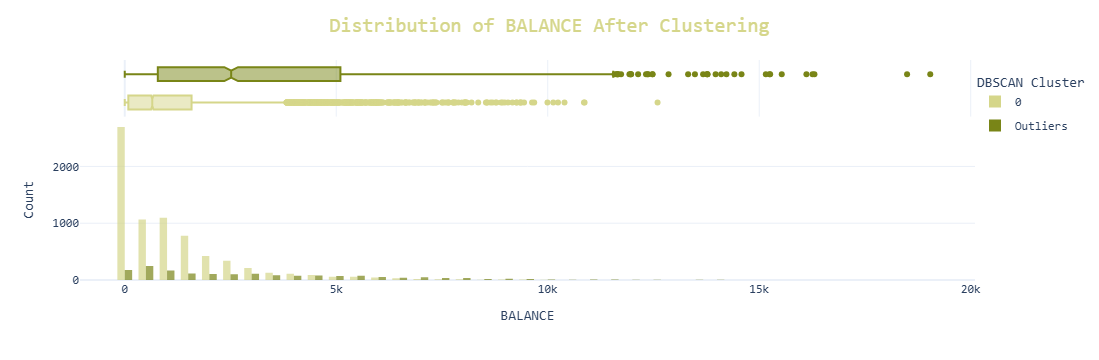

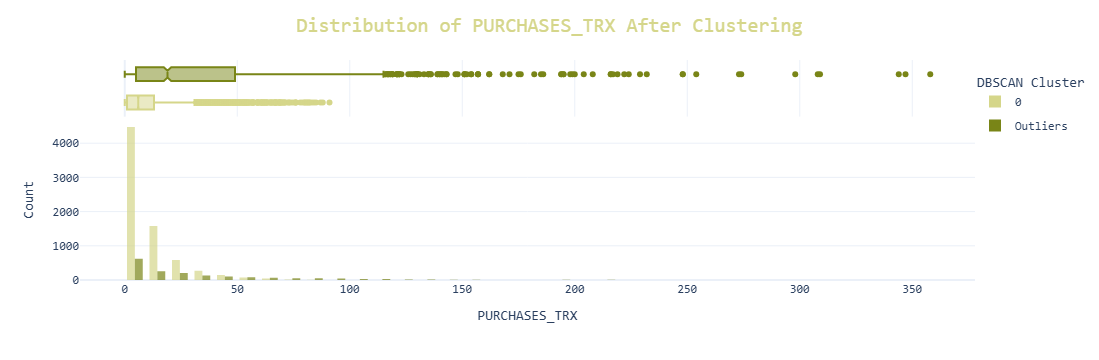

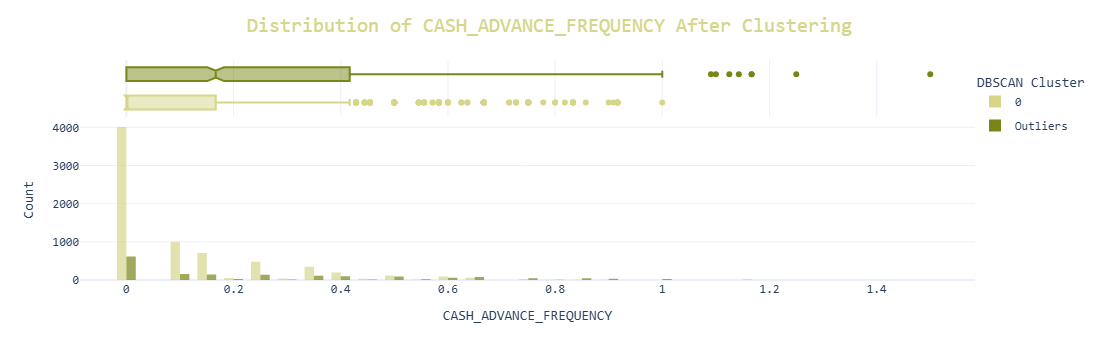

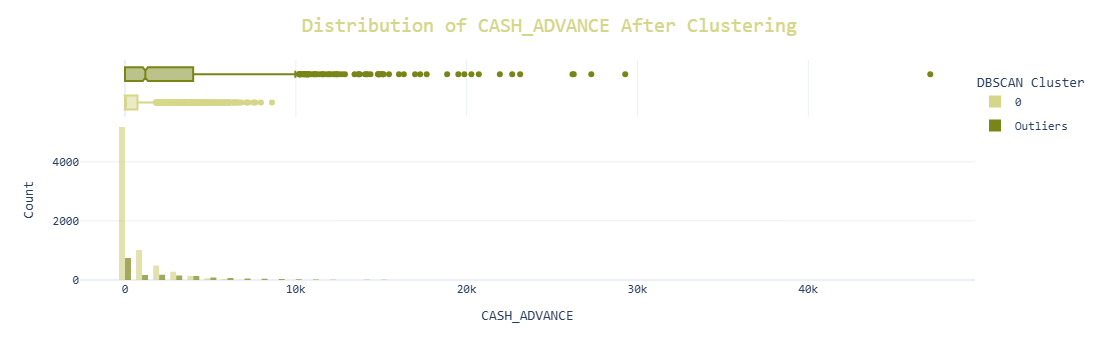

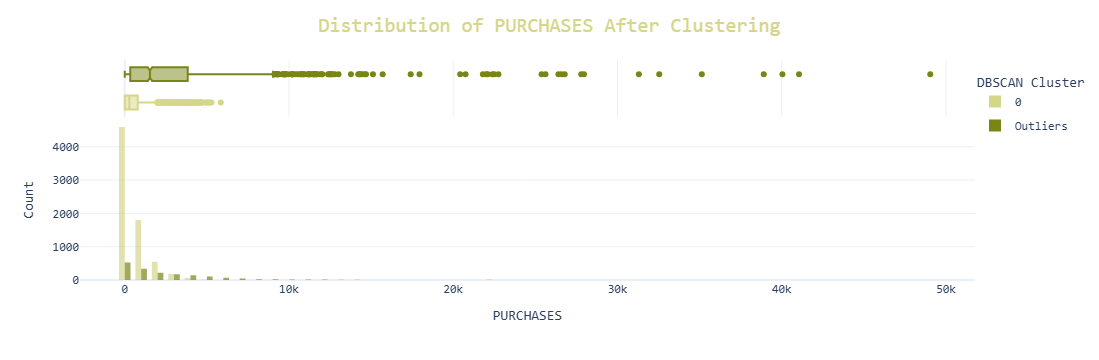

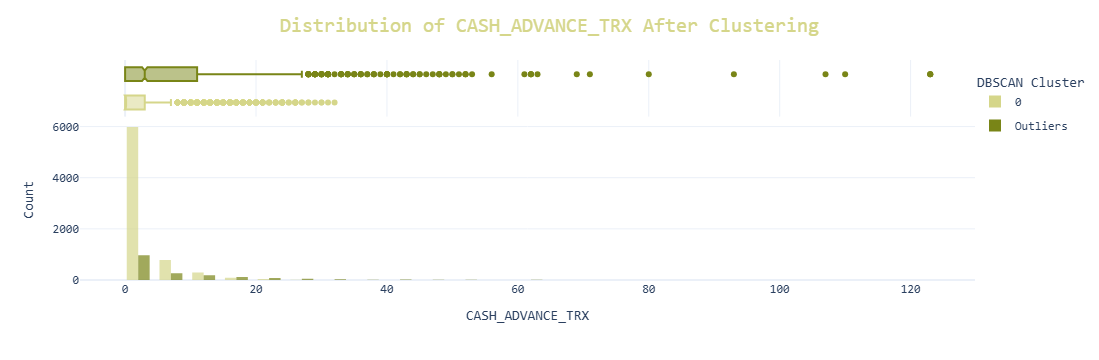

In [69]:
features = ['BALANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE', 'PURCHASES', 'CASH_ADVANCE_TRX']

import plotly.io as pio
custom_colors = ["#798517", "#B71C1B", "#D5D68A", "#A6AD3C", "#F2ECC6"]  

for feature in features:
    temp = pio.templates['plotly_white'] 
    
    fig = px.histogram(dbscan_clustered_df, x=feature, color='DBSCAN Cluster', template=temp,
                       marginal='box', opacity=0.7, nbins=50, color_discrete_sequence=[custom_colors[2], custom_colors[0]],
                       barmode='group', histfunc='count')
    
    fig.update_layout(
        font_family='monospace',
        title=dict(text=f'Distribution of {feature} After Clustering', x=0.5, y=0.95,
                   font=dict(color=custom_colors[2], size=20)),
        xaxis_title_text=feature,
        yaxis_title_text='Count',
        legend=dict(x=1, y=0.96, bordercolor=custom_colors[1], borderwidth=0, tracegroupgap=5),
        bargap=0.3,
    )
    fig.show()